In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import heapq
import time
import random
import pandas as pd 

#FOR IMAGE 1

K1 = np.array([[1421.9, 0.5, 509.2],[ 0, 1421.9, 380.2],[ 0, 0, 1]])
K2 = np.array([[1421.9, 0.5, 509.2],[ 0, 1421.9, 380.2],[ 0, 0, 1]])

# #FOR IMAGE 2
# #CAMERA A
# K1 = np.array([[5426.566895, 0.678017, 330.096680],
#                  [0.000000, 5423.133301, 648.950012],
#                  [0.000000,  0.000000, 1.000000]])
# R1 = np.array([[0.140626, 0.989027, -0.045273],
#                  [0.475766, -0.107607, -0.872965],
#                [-0.868258, 0.101223, -0.485678]])
# t1 = np.array([[67.479439, -6.020049, 40.224911]])

# #CAMERA B
# K2 = np.array([[5426.566895, 0.678017, 387.430023],
#                  [0.000000, 5423.133301, 620.616699],
#                  [0.000000, 0.000000, 1.000000]])
# R2 = np.array([[0.336455, 0.940689, -0.043627],
#                  [0.446741, -0.200225, -0.871970],
#                  [-0.828988, 0.273889, -0.487611]])
# t2 = np.array([[62.882744, -21.081516, 40.544052]])

#IMAGE Deer
# K1 = np.array([[ 1.23451531e+03, -2.30410376e+00,  5.64016232e+02],[ 0.00000000e+00,  1.23420888e+03,  7.29026308e+02],[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])
# K2 = K1

=======================Interest points detection & feature description========================
Use sift to  detect Interest points and feature description
img1 shape is (800, 1200, 3)
img2 shape is (800, 1200, 3)
Image 1 find 1432 key points
Image 1 descriptor size is (1432, 128)
Image 2 find 1289 key points
Image 2 descriptor size is (1289, 128)
=======================Feature matching by features========================
463


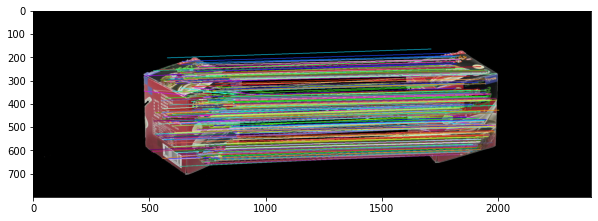

Step 1 cost 36.13667178153992 seconds


In [2]:
def show(image):
    plt.figure(figsize=(10,10))
    image = image[:,:,::-1]
    plt.clf()
    plt.imshow(image)
    #plt.axis('off')
    plt.show()

    
def Kp_and_Feature_Des(data1_path, data2_path, method):
    img1 = cv2.imread(data1_path)
    img2 = cv2.imread(data2_path)    
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    while(img2.shape[0] > 1000):
        img1 = cv2.resize(img1,None,fx=0.5, fy=0.5)
        img1_gray = cv2.resize(img1_gray,None,fx=0.5, fy=0.5)
        img2 = cv2.resize(img2,None,fx=0.5, fy=0.5)
        img2_gray = cv2.resize(img2_gray,None,fx=0.5, fy=0.5)
    print(f"img1 shape is {img1.shape}")
    print(f"img2 shape is {img2.shape}")
        
    # Scale-Invariant Feature Transform
    if method == 'sift':
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(img1_gray, None)
        kp2, des2 = sift.detectAndCompute(img2_gray, None)  
    
    
    # Speeded-Up Robust Features
    if method == 'surf':
        surf = cv2.SIFT_create()
        kp1, des1 = surf.detectAndCompute(img1_gray, None) 
        kp2, des2 = surf.detectAndCompute(img2_gray, None)
        
    # Oriented FAST and Rotated BRIEF
    if method == 'orb':
        orb = cv2.SIFT_create()
        kp1, des1 = orb.detectAndCompute(img1_gray, None)
        kp2, des2 = orb.detectAndCompute(img2_gray, None)
    print(f"Image 1 find {len(kp1)} key points")
    print(f"Image 1 descriptor size is {des1.shape}")
    print(f"Image 2 find {len(kp2)} key points")
    print(f"Image 2 descriptor size is {des2.shape}")
    return kp1, kp2, des1, des2, img1, img2


def Matching(Descriptors1, Descriptors2, threshold):
    Best_Match = -1 * np.ones(Descriptors1.shape[0],dtype = int)
    for i in range(Descriptors1.shape[0]):
        Score = []
        for j in range(Descriptors2.shape[0]):
            diff = Descriptors1[i] - Descriptors2[j]
            diff = diff**2
            diff = sum(diff)
            Score.append(diff)
        min_num_index_list = map(Score.index, heapq.nsmallest(2, Score))
        First , Second = list(min_num_index_list)
        f1 = Descriptors1[i]
        f2 = Descriptors2[First]
        f2_ = Descriptors2[Second]
        
        ratio_distance = np.sqrt(sum((f1 - f2)**2)) / np.sqrt(sum((f1 - f2_)**2))
        if ratio_distance < threshold:
            Best_Match[i] = First
    return Best_Match

def Combine(img1, img2, Best_Match, Key_Point1, Key_Point2):
    ha, wa = img1.shape[:2]
    hb, wb = img2.shape[:2]
    combine = np.zeros((max(ha, hb), wa + wb, 3), dtype="uint8")
    combine[0:ha, 0:wa] = img1
    combine[0:hb, wa:] = img2
    #show(combine)
    c =0
    for i in range(len(Best_Match)):
        if Best_Match[i]!=-1:
            c += 1
            color = np.random.randint(0, high = 255, size = (3,))
            color = (int(color[0]), int(color[1]), int(color[2]))
            ptA = int(Key_Point1[i].pt[0]), int(Key_Point1[i].pt[1])
            ptB = int(Key_Point2[Best_Match[i]].pt[0] + wa), int(Key_Point2[Best_Match[i]].pt[1] )
            cv2.line(combine, ptA, ptB, color, 2)
    print(c)
    show(combine)


    


if __name__ == "__main__":
    ### Settings
#     data1_path = './deer1.jpg'
#     data2_path = './deer2.jpg'
    data1_path = './Mesona1.JPG'
    data2_path = './Mesona2.JPG'
#     data1_path = './Statue1.bmp'
#     data2_path = './Statue2.bmp'
    random.seed(1234)
    ### step 1
    print("=======================Interest points detection & feature description========================")
    start = time.time()
    ### Can set the detecting and feature description method with method sift surf orb
    method = 'sift'
    print(f"Use {method} to  detect Interest points and feature description")
    Key_Point1 ,Key_Point2 , Descriptors1, Descriptors2, img1, img2 = Kp_and_Feature_Des(data1_path,data2_path,method)
    h1, w1, c1 = img1.shape
    h2, w2, c2 = img2.shape
    print("=======================Feature matching by features========================")
    threshold = 0.7
    Best_Match = Matching(Descriptors1, Descriptors2, threshold)
    Combine(img1, img2, Best_Match, Key_Point1, Key_Point2)
    end = time.time()
    print(f"Step 1 cost {end-start} seconds")

=======================RANSAC to find Inlier========================


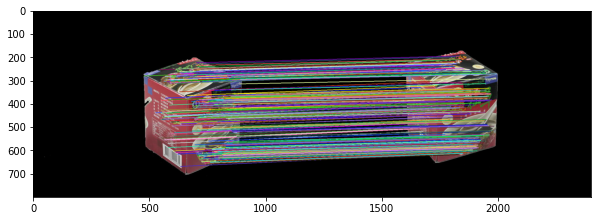

Step 2 cost 3.690688371658325 seconds


In [3]:
def Find_Good_pairs(Key_Point1, Key_Point2, Best_Match, repeat_times, random_number, threshold):
    max_count = -1
    Point1_array = []
    Key_Point1 = np.array(Key_Point1)
    for i in range(len(Key_Point1)):
        temp = Key_Point1[i].pt
        Point1_array.append(temp)
    Point1_array = np.array(Point1_array)
    Point2_array = []
    Key_Point2 = np.array(Key_Point2)
    for i in range(len(Key_Point2)):
        temp = Key_Point2[i].pt
        Point2_array.append(temp)
    Point2_array = np.array(Point2_array)
    index = np.where(Best_Match!=-1)
    
    for i in range(repeat_times):
        random_pick = random.sample(list(index[0]), random_number)
        
        Image1_point = Point1_array[random_pick].T
        Image2_point = Point2_array[Best_Match[random_pick]].T
        Image1_point, Image2_point = Normalize(Image1_point, Image2_point, random_number)
        F = Find_F(Image1_point, Image2_point, random_number)
        pts_temp1, pts_temp2, inlier = Find_Inlier(Point1_array[index].T, Point2_array[Best_Match[index]].T, F, threshold)
        if inlier > max_count:
            max_count = inlier
            Inner_group1 = pts_temp1
            Inner_group2 = pts_temp2
            F_best = F
    Inner_group1 = np.array(Inner_group1).reshape(-1,2)
    Inner_group2 = np.array(Inner_group2).reshape(-1,2)
    return Inner_group1, Inner_group2, F_best
    
def Normalize(pt_1, pt_2, random_number):
    temp = np.ones((1, random_number))
    pt_1 = np.concatenate((pt_1, temp), axis = 0)
    pt_2 = np.concatenate((pt_2, temp), axis = 0)
    T1 = np.array([[2.0/w1, 0, -1], [ 0, 2/h1, -1], [ 0,  0, 1.0]])
    T2 = np.array([[2.0/w2, 0, -1], [ 0, 2/h2, -1], [ 0,  0, 1.0]])
    pt_1 = np.dot(T1, pt_1)
    pt_2 = np.dot(T2, pt_2)
    return pt_1, pt_2 

def Find_F(pt_1, pt_2, random_number):
    A = np.ones((random_number, 9))
    T1 = np.array([[2.0/w1, 0, -1], [ 0, 2/h1, -1], [ 0,  0, 1.0]])
    T2 = np.array([[2.0/w2, 0, -1], [ 0, 2/h2, -1], [ 0,  0, 1.0]])
    for i in range(random_number):
        A[i,0:3] = pt_2[0,i] * pt_1[:,i].T
        A[i,3:6] = pt_2[1,i] * pt_1[:,i].T
        A[i,6:9] = pt_1[:,i].T
    _,_,V_T= np.linalg.svd(A)
    V = V_T.T
    F_temp = V[:,-1].reshape(3,3)
    U, S, V_T = np.linalg.svd(F_temp)
    
    S1 = np.zeros((3, 3))
    S1[0, 0] = S[0]
    S1[1, 1] = S[1]
    F = np.dot(np.dot(U, S1), V_T)
    F = np.dot(T2.T, np.dot(F, T1))
    F = F/F[2,2]
    return F
    
def Find_Inlier(pt_1, pt_2, F, threshold=0.8):
    num = pt_1.shape[1]
    temp = np.ones((1,num))
    pt_1 = np.concatenate((pt_1, temp), axis = 0)
    pt_2 = np.concatenate((pt_2, temp), axis = 0)
    inlier = 0
    pts_temp1 = []
    pts_temp2 = []
    for i in range(num):
        x2_F = np.dot(pt_2[:,i].T, F)
        x2_F_x1 = abs(np.dot(x2_F, pt_1[:,i]))
        if(x2_F_x1<threshold):
            pts_temp1.append([pt_1[0:2, i]])
            pts_temp2.append([pt_2[0:2, i]])
            inlier = inlier+1
    return pts_temp1, pts_temp2, inlier

def Combine1(img1, img2,Inner_group1, Inner_group2):
    ha, wa = img1.shape[:2]
    hb, wb = img2.shape[:2]
    combine = np.zeros((max(ha, hb), wa + wb, 3), dtype="uint8")
    combine[0:ha, 0:wa] = img1
    combine[0:hb, wa:] = img2
    #show(combine)
    
    for i in range(len(Inner_group1)):
        color = np.random.randint(0, high = 255, size = (3,))
        color = (int(color[0]), int(color[1]), int(color[2]))
        ptA = int(Inner_group1[i,0]) , int(Inner_group1[i,1])
        ptB = int(Inner_group2[i,0]  + wa), int(Inner_group2[i,1])
        cv2.line(combine, ptA, ptB, color, 2)
    show(combine)
    
if __name__ == "__main__":
    # step2
    print("=======================RANSAC to find Inlier========================")
    start = time.time()
    repeat_times = 3000
    random_number = 8
    threshold = 0.01
    Inner_group1, Inner_group2, F = Find_Good_pairs(Key_Point1, Key_Point2, Best_Match, repeat_times, random_number, threshold)
    Combine1(img1, img2,Inner_group1, Inner_group2)
    end = time.time()
    print(f"Step 2 cost {end-start} seconds")

In [4]:
if __name__ == "__main__":
    F_truth, mask = cv2.findFundamentalMat(Inner_group1, Inner_group2, cv2.FM_8POINT + cv2.FM_RANSAC)
    print (f"F_truth:\n {F_truth}")
    print(f"F:\n {F}")

F_truth:
 [[-3.80613472e-08 -1.74755657e-06 -1.15648546e-03]
 [ 9.28468648e-07 -1.47618045e-07  1.69095892e-02]
 [ 2.86664559e-04 -1.60216185e-02  1.00000000e+00]]
F:
 [[ 1.02439304e-07 -7.53093343e-08 -2.30490438e-03]
 [-7.48150540e-07  9.42614365e-08  1.76523681e-02]
 [ 1.22593653e-03 -1.68105234e-02  1.00000000e+00]]


Start processing step 3
Img 1 shape is (800, 1200, 3)
Img 2 shape is (800, 1200, 3)
Start Draw lines
lines_1to2 shape is (3, 354)
pts1 shape is (354, 3)
pts2 shape is (354, 3)


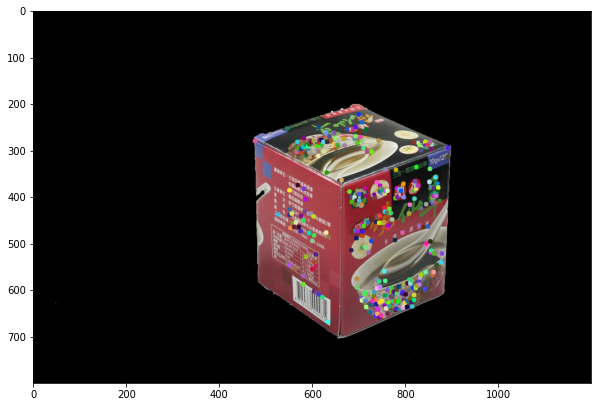

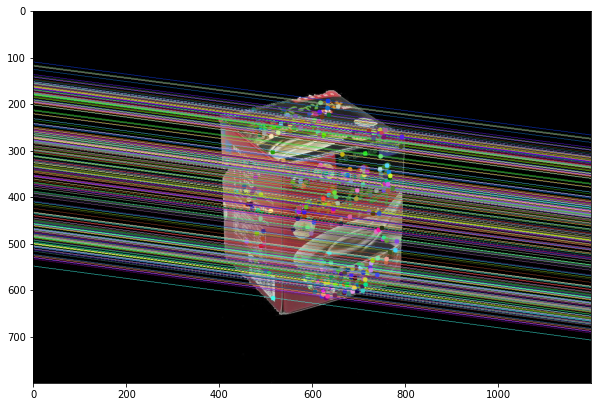

Step 3 cost 0.3334195613861084 seconds


In [5]:
def drawlines(img1, img2, lines_1to2,lines_2to1, pts1, pts2):
#     img1 - image on which we draw the epilines for the points in img2
#     lines - corresponding epilines
    r, c, channel = img1.shape
#     lines = cv2.computeCorrespondEpilines(pts2[:,:2].reshape(-1,1,2), 2,F)
#     lines = lines.reshape(-1,3)
    print(f"lines_1to2 shape is {lines_1to2.shape}")
    print(f"pts1 shape is {pts1.shape}")
    print(f"pts2 shape is {pts2.shape}")
    for line_1to2,line_2to1, pt1, pt2 in zip(lines_1to2.T,lines_2to1.T, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -(line_1to2[2] + line_1to2[0] * 0) / line_1to2[1] ])
        x1, y1 = map(int, [c, -(line_1to2[2] + line_1to2[0] * (c)) / line_1to2[1] ])
        img2 = cv2.line(img2, (x0, y0), (x1, y1), color, 1)
        x0, y0 = map(int, [0, -(line_2to1[2] + line_2to1[0] * 0) / line_2to1[1] ])
        x1, y1 = map(int, [c, -(line_2to1[2] + line_2to1[0] * (c)) / line_2to1[1] ])
#         img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1[:2]), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2[:2]), 5, color, -1)
    return img1, img2

if __name__ == "__main__":
    print("Start processing step 3")
    start = time.time()
    pts1 = np.copy(Inner_group1)
    pts2 = np.copy(Inner_group2)
    temp = np.ones((pts1.shape[0],1))
    pts1 = np.concatenate((pts1, temp), axis = 1).astype(np.int32)
    pts2 = np.concatenate((pts2, temp), axis = 1).astype(np.int32)
    lines_1to2 = np.dot(F, pts1.T)
    lines_2to1 = np.dot(F.T, pts2.T)
    print(f"Img 1 shape is {img1.shape}")
    print(f"Img 2 shape is {img2.shape}")
    print("Start Draw lines")
    output1, output2 = drawlines(img1, img2,lines_1to2,lines_2to1, pts1, pts2)
    show(output1)
    show(output2)
    end = time.time()
    print(f"Step 3 cost {end-start} seconds")

In [6]:
def Get_essential(E):
    U, S, V_T = np.linalg.svd(E)
    m = (S[0] + S[1]) / 2
    E = np.dot(np.dot(U, np.diag([m, m, 0])), V_T)
    print(f"Real Essentail matrix is :\n{E}\n")
    U, S, V_T = np.linalg.svd(E)
    W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    return U, S, V_T, W

def Four_solution(U, S, V_T, W):
    #Four Extrinsic matrix combination
    t1 = U[:,2].reshape(-1,1)
    t2 = -t1
    R1 = np.dot(np.dot(U, W), V_T)
    R2 = np.dot(np.dot(U, W.T), V_T)
    solution = np.zeros((4,3,4))
    solution[0,:,:] = np.concatenate((R1, t1), axis = 1)
    solution[1,:,:] = np.concatenate((R1, t2), axis = 1)
    solution[2,:,:] = np.concatenate((R2, t1), axis = 1)
    solution[3,:,:] = np.concatenate((R2, t2), axis = 1)
    return solution
if __name__ == "__main__":
    print("start processing step 4")
    start = time.time()
    E = np.dot(K2.T, np.dot(F, K1))
    print(f"Essentail matrix is calculated by K * F * K :\n{E}\n")
    U, S, V_T, W = Get_essential(E)
    solution = Four_solution(U, S, V_T, W)
    print(f"Four possible extrinsic matirx answer \n{solution}")
    end = time.time()
    print(f"step 4 cost {end-start} seconds")
    

start processing step 4
Essentail matrix is calculated by K * F * K :
[[  0.20711174  -0.15218755  -3.24388697]
 [ -1.51253764   0.18999232  24.60803524]
 [  1.41287348 -23.90595432   0.65142549]]

Real Essentail matrix is :
[[  0.20506415  -0.17779656  -3.18480639]
 [ -1.49546802   0.36560146  24.15324789]
 [  1.45142069 -24.36391018   0.47567255]]

Four possible extrinsic matirx answer 
[[[ 0.99519244 -0.0704716   0.0680129   0.9913912 ]
  [ 0.0713573   0.99739365 -0.01067914  0.13082698]
  [-0.06708305  0.01548102  0.99762729 -0.00527154]]

 [[ 0.99519244 -0.0704716   0.0680129  -0.9913912 ]
  [ 0.0713573   0.99739365 -0.01067914 -0.13082698]
  [-0.06708305  0.01548102  0.99762729  0.00527154]]

 [[ 0.98028166  0.19050819  0.05248323  0.9913912 ]
  [ 0.18933224 -0.98155326  0.02658018  0.13082698]
  [ 0.05657883 -0.01611929 -0.998268   -0.00527154]]

 [[ 0.98028166  0.19050819  0.05248323 -0.9913912 ]
  [ 0.18933224 -0.98155326  0.02658018 -0.13082698]
  [ 0.05657883 -0.01611929 -0.

In [7]:
def Find_best_extrinsic(x1, x2, solution):
    Extrinsic_1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
    Camera_matrix_1 = np.dot(K1, Extrinsic_1)
    
    max_count = 0
    for i in range(4):
        print(f"i= {i}" ,end = '\t')
        Camera_matrix_2 = np.dot(K2, solution[i])
        count = 0
        for j in range(len(x1)):
            X = Triangulation(x1[j], x2[j], Camera_matrix_1, Camera_matrix_2)
            
            Extrinsic_2 = solution[i]
            
            
            Camera1_R = Extrinsic_1[:,0:3]
            Camera1_T = Extrinsic_1[:,3]
            
            Camera2_R = Extrinsic_2[:,0:3]
            Camera2_T = Extrinsic_2[:,3]
            
            Camera1_Center = -1 * np.dot(Camera1_R.T, Camera1_T).reshape(-1, 1)
            Camera2_Center = -1 * np.dot(Camera2_R.T, Camera2_T).reshape(-1, 1)
            
            ViewDirectopm_1 = (Camera1_R[2,:].T).reshape(1, -1)
            ViewDirectopm_2 = (Camera2_R[2,:].T).reshape(1, -1)
            
            X = (X[:3]/X[3]).reshape(-1, 1)
            
            Direction_1 = np.dot(ViewDirectopm_1, X-Camera1_Center )
            Direction_2 = np.dot(ViewDirectopm_2, X-Camera2_Center)
            

            if (Direction_1 >= 0 and Direction_2 >= 0):
                count = count + 1
        print(f"count is {count}")
        if count > max_count :
            max_count = count
            Camera_matrix_2_best = Camera_matrix_2
    print(f"Find best Camera_matrix_2 is \n{Camera_matrix_2_best}")
    return Camera_matrix_1, Camera_matrix_2_best

def Triangulation(x1, x2, Camera_matrix_1, Camera_matrix_2):
    A = np.zeros((4,4))
    A[0,:] = x1[0] * Camera_matrix_1[2,:] - Camera_matrix_1[0,:]
    A[1,:] = x1[1] * Camera_matrix_1[2,:] - Camera_matrix_1[1,:]
    A[2,:] = x2[0] * Camera_matrix_2[2,:] - Camera_matrix_2[0,:]
    A[3,:] = x2[1] * Camera_matrix_2[2,:] - Camera_matrix_2[1,:]
    U, S, V_T = np.linalg.svd(A)
    V = V_T.T
    return V[:,-1]/V[3,3]

if __name__ == "__main__":
    print("start processing step 5")
    start = time.time()
    x1 = np.copy(Inner_group1)
    x2 = np.copy(Inner_group2)
    Camera_matrix_1, Camera_matrix_2 = Find_best_extrinsic(x1, x2, solution)
    end = time.time()
    print(f"Step 5 cost {end-start} seconds")

start processing step 5
i= 0	count is 0
i= 1	count is 354
i= 2	count is 0
i= 3	count is 0
Find best Camera_matrix_2 is 
[[ 1.38094112e+03 -9.18219389e+01  6.04694011e+02 -1.40704029e+03]
 [ 7.59579710e+01  1.42407991e+03  3.64113219e+02 -1.84018646e+02]
 [-6.70830538e-02  1.54810201e-02  9.97627286e-01  5.27154354e-03]]
Step 5 cost 0.06848430633544922 seconds


start processing step 6


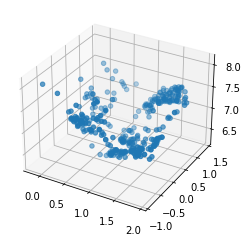

In [11]:
if __name__ == "__main__":
    print("start processing step 6")
    pd.DataFrame(x1).to_csv("2D_d.csv", header=None, index=None)
    World_corrdinate = []
    for i in range(len(x1)):
        X = Triangulation(x1[i], x2[i], Camera_matrix_1, Camera_matrix_2)
        World_corrdinate.append(X[0:3])
    
    World_corrdinate = np.array(World_corrdinate)
    pd.DataFrame(World_corrdinate).to_csv("3D_d.csv", header=None, index=None)
    pd.DataFrame(Camera_matrix_1).to_csv("camera_matrix.csv", header=None, index=None)
    ax = plt.subplot(111, projection='3d') 
    ax.scatter(World_corrdinate[:,0], World_corrdinate[:,1], World_corrdinate[:,2])
    plt.show()
